### Deep Hedging

Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Evaluation of how good $V_{T}$ hedge $Z$ by convex risk measure $\rho$
$$
\rho(-Z + V_T).
$$
By cash invariant of convex risk measure we have 
$$
\rho(-Z + V_T) = \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0,
$$
which means that the risk increase at maturity $T$ is indeed how much we subtract at time $0$, so implicitly we are actually compare the discounted value. This idea is also reflected in the definition of OCE measure below (a special case of convex risk measure).

Our goal is to find the best strategy $H$ under $\rho$:
$$
\pi(-Z) = \min_{H} \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0.
$$
In particular we choose OCE measure 
$$
\rho(X) = \inf_{w \in \mathbb{R}}\{w + \mathbb{E}_{\mathbb{P}}[l(-X-w)]\}
$$
where $l(x)$ represent risk (with $u$ to be utility function).
- Entropic risk measure: $l(x) = \exp(\lambda x) - \frac{1}{\lambda}(1+\log\lambda)$, $\lambda > 0$
\begin{align*}
\rho(X) &= \frac{1}{\lambda}\log\Big(\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)\\
\omega^{*} &= \frac{1}{\lambda}\log\Big(\lambda\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)
\end{align*}

- Expected shortfall: $l(x) = \frac{1}{1-\alpha}\max(x,0)$, $\alpha \in (0,1)$
\begin{align*}
\rho(X) &= \frac{1}{1-\alpha}\int_{0}^{1-\alpha}\mathrm{VaR}_{\gamma}(X)d\gamma\\
\omega^{*} &= -\mathrm{VaR}_{1-\alpha}(X)
\end{align*}

- Square loss: $l(x) = \frac{x^2 + 1}{2}$
\begin{align*}
\rho(X) &= \frac{1}{2}\mathrm{Var}_{\mathbb{P}}[X] -  \mathbb{E}_{\mathbb{P}}[X] \\
\omega^{*} &= -\mathbb{E}_{\mathbb{P}}[X]
\end{align*}
At the end we specify $V_0 = \omega^{*}$ to be the initial wealth i.e. the price of payoff. 

Numerically, we are solving the following minimization problem 
$$
\rho(X) = \inf_{H \in \mathcal{NN}}\inf_{V_0 \in \mathbb{R}}\Big\{V_0 + \mathbb{E}_{\mathbb{P}}\Big[l\big(Z + C_T - V_T \big)\big)\Big]\Big\}
$$

- ! Price process need to be discounted



In [1]:
import numpy as np
import torch

from math import ceil
import matplotlib.pyplot as plt

from neuralhedge.nn import datahedger, contigent, mlp, loss
from neuralhedge.market import stochastic
from neuralhedge._utils.plotting import plot_pnl, plot_history

from importlib import reload
reload(stochastic)
reload(loss)

torch.manual_seed(1)


### Black-Scholes

In [2]:
n_paths = 5000
step_size = 1/365
maturity = 30/365
n_steps = ceil(maturity / step_size)
initial_value = 1.
mu = 0.0
sigma = 0.2

blackscholes = stochastic.BlackScholes(mu = mu, 
                            sigma = sigma,
                            n_paths = n_paths,
                            n_steps = n_steps,
                            step_size = step_size)
blackscholes.stimulate(initial_value = initial_value)
option = contigent.EuropeanVanilla(strike = 1.)

paths = blackscholes.prices
information = torch.cat([
    torch.log(blackscholes.prices),
    blackscholes.times_inverse
    ], axis = -1)
payoff = option.payoff(blackscholes.prices)

n_asset = paths.shape[-1]
data_set = [paths, information, payoff]


/opt/homebrew/Caskroom/miniforge/base/envs/NeuralHedge/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.02377474308013916: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


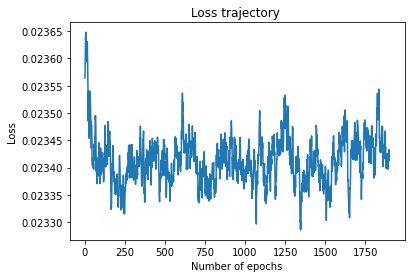

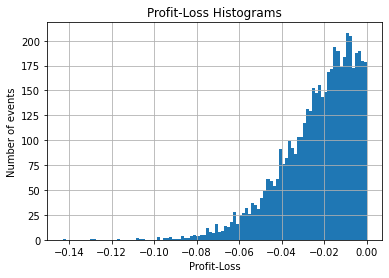

Price:  [0.02339498]


In [3]:
dataset_market = datahedger.MarketDataset(data_set)
model = mlp.NeuralNet(n_output = n_asset)
hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market) 
plot_history(history)
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())


Loss=0.02394295483827591: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


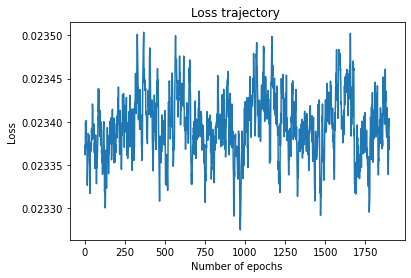

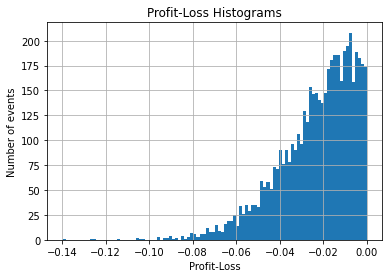

Price:  0.023236353


In [4]:
history = hedger.fit(dataset_market, criterion=loss.SquareMeasure()) 
plot_history(history)
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())

Loss=0.03512488305568695: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


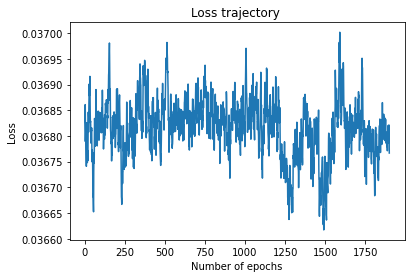

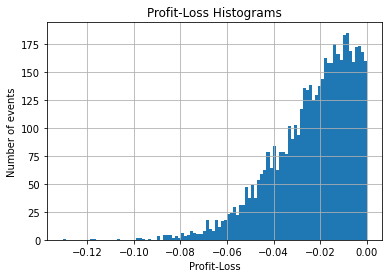

Price:  0.019411141


In [5]:
alpha = 0.5
q = 1-alpha
history = hedger.fit(dataset_market, criterion=loss.ExpectedShortfall(0.5)) 
plot_history(history)
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())

Loss=0.09659353643655777: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


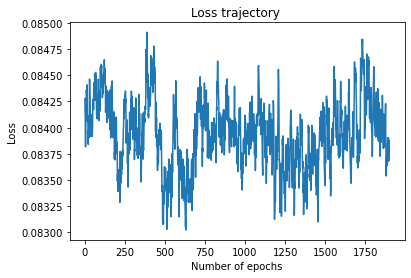

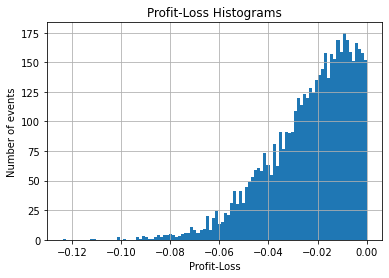

Price:  0.07648384


In [6]:
alpha = 0.99
q = 1-alpha
history = hedger.fit(dataset_market, criterion=loss.ExpectedShortfall(q)) 
plot_history(history)
pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())

### Deep Hedger

In [5]:
# models = [mlp.NeuralNet(n_output = n_asset) for t in range(n_steps)]
# hedger = datahedger.DeepHedger(models) 
# history = hedger.fit(dataset_market, EPOCHS=200)    
# # plot_history(history)

# pnl = hedger.compute_pnl(data_set).detach().numpy()
# plot_pnl(pnl)
# print('Price: ', hedger.pricer().detach().numpy())

### Heston Model

In [6]:
n_paths = 5000
step_size = 1/365
maturity = 30/365
n_steps = ceil(maturity / step_size)

kappa = 1.
theta = 0.04
sigma = 0.2
rho = -0.7

v0 = 0.04
s0 = 100.
initial_value = (s0, v0)

heston = stochastic.Heston(kappa = kappa,
                            theta = theta,
                            sigma = sigma,
                            rho = rho,
                            n_paths = n_paths,
                            n_steps = n_steps,
                            step_size = step_size)
heston.stimulate(initial_value = initial_value)
option = contigent.EuropeanVanilla(strike = s0)

paths = torch.cat([heston.prices, heston.prices_varswap],axis = -1)
information = torch.cat([
    torch.log(heston.prices),
    heston.variances,
    heston.times_inverse
    ], axis = -1)
payoff = option.payoff(heston.prices)

n_asset = paths.shape[-1]
data_set = [paths, information, payoff]

Loss=3.780670642852783: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


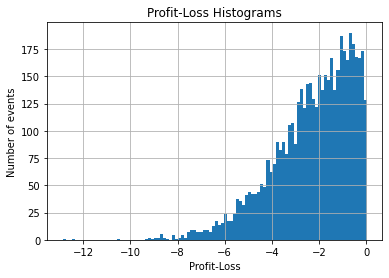

Price:  [5.351147]


In [7]:
dataset_market = datahedger.MarketDataset(data_set)
model = mlp.NeuralNet(n_output = n_asset)
hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market)    
# plot_history(history)

pnl = hedger.compute_pnl(data_set).detach().numpy()
plot_pnl(pnl)
print('Price: ', hedger.pricer().detach().numpy())